# Chapter 10. Betting Size
### 2, 3번 연습문제 풀이

In [1]:
from mlfinlab import data_structures, features, filters, labeling, util, sampling, structural_breaks, microstructural_features
from mlfinlab import bet_sizing as bs

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn import metrics
from sklearn.decomposition import PCA

# matplotlib 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df=pd.read_csv('dollar_bars (1).csv') # dollar_bar 파일
df.index = pd.to_datetime(df.date_time) # index를 날짜_시간으로 바꾸기
dollar_bars=df.drop('date_time',axis=1) # 중복된 행 없애기

In [3]:
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time') # 중복 날짜 없애기
dollar_bars

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2015-01-01 23:00:24,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478
2015-01-02 07:07:35,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514
2015-01-02 09:35:57,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152
2015-01-02 12:59:42,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502
2015-01-02 14:19:34,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332
...,...,...,...,...,...,...,...
2016-12-30 20:59:59,2236.00,2236.50,2235.75,2236.50,31334,70065316.00,1408
2016-12-30 21:00:00,2236.25,2237.50,2235.75,2235.75,31456,70355994.75,832
2016-12-30 21:00:24,2236.00,2237.00,2235.00,2236.25,31319,70029228.00,1123


### 1. Side 구하기

In [4]:
from mlfinlab import *

In [6]:
def mavg(df,fast_window,slow_window): #이동평균선 
    df['fast_mavg'] = df['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
    df['slow_mavg'] = df['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
    return df
def side(df): #이동평균선에 따른 side
    df['side'] = np.nan
    long_signals = df['fast_mavg'] >= df['slow_mavg'] #매수
    short_signals = df['fast_mavg'] < df['slow_mavg']  #매도
    df.loc[long_signals, 'side'] = 1
    df.loc[short_signals, 'side'] = -1
    # 시차 1개 줘서 Look ahead bias 없애기
    df['side'] = df['side'].shift(1)
    return df

In [7]:
dollar_bars=mavg(dollar_bars,20,60)
dollar_bars=side(dollar_bars)

In [15]:
dollar_bars

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,fast_mavg,slow_mavg,side
date_time,,,,,,,,,,
2015-01-01 23:00:24,2053.00,2056.75,2051.00,2056.75,34102,70001096.75,8478,NaN,NaN,NaN
2015-01-02 07:07:35,2056.75,2067.25,2056.25,2064.00,33968,70010061.25,14514,NaN,NaN,NaN
2015-01-02 09:35:57,2064.00,2067.25,2058.75,2060.50,33972,70087834.25,16152,NaN,NaN,NaN
2015-01-02 12:59:42,2060.50,2062.00,2057.75,2061.00,33985,70006169.75,15502,NaN,NaN,NaN
2015-01-02 14:19:34,2061.00,2064.25,2058.75,2063.75,33958,70000723.25,12332,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2016-12-30 20:59:59,2236.00,2236.50,2235.75,2236.50,31334,70065316.00,1408,2234.1750,2240.604167,-1.0
2016-12-30 21:00:00,2236.25,2237.50,2235.75,2235.75,31456,70355994.75,832,2233.9875,2240.375000,-1.0
2016-12-30 21:00:24,2236.00,2237.00,2235.00,2236.25,31319,70029228.00,1123,2233.9000,2240.220833,-1.0


### 2. Tripple Barrier

In [39]:
volatility = util.get_daily_vol(close=dollar_bars.close, lookback=500) #변동성, 수평 barrier 폭
cusum_events = filters.cusum_filter(dollar_bars.close, threshold = volatility.mean()) #cumsum events
vertical_barriers = labeling.add_vertical_barrier(t_events=cusum_events, close=dollar_bars.close, num_days=30) #vertical barrier 세우기

In [42]:
# tripple barrier 구하기
pt_sl = [1, 2]

min_ret = 0.003
tripple_barrier_events = labeling.get_events(close=dollar_bars.close,
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=volatility,
                                               min_ret=min_ret,
                                               num_threads=2,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction = dollar_bars['side'])

2020-08-12 14:22:08.421549 100.0% apply_pt_sl_on_t1 done after 0.28 minutes. Remaining 0.0 minutes.


In [43]:
tripple_barrier_events

,t1,trgt,side,pt,sl
2015-01-05 17:26:59,2015-01-06 16:01:22,0.003973,-1.0,1,2
2015-01-06 16:19:17,2015-01-06 17:04:56,0.004741,-1.0,1,2
2015-01-06 18:27:02,2015-01-06 19:53:59,0.004349,-1.0,1,2
2015-01-06 19:53:59,2015-01-06 20:57:41,0.004298,-1.0,1,2
2015-01-07 13:06:59,2015-01-07 17:08:58,0.004380,1.0,1,2
...,...,...,...,...,...
2016-12-13 17:16:09,2016-12-28 20:59:50,0.005451,1.0,1,2
2016-12-14 20:09:51,2016-12-30 19:02:58,0.005395,-1.0,1,2
2016-12-15 16:03:52,2016-12-30 15:29:58,0.005829,1.0,1,2
2016-12-28 17:41:36,2016-12-30 15:29:58,0.004551,-1.0,1,2


In [44]:
bins = labeling.get_bins(tripple_barrier_events, dollar_bars.close)
bins

,ret,trgt,bin,side
2015-01-05 17:26:59,0.005232,0.003973,1,-1.0
2015-01-06 16:19:17,0.005521,0.004741,1,-1.0
2015-01-06 18:27:02,-0.009724,0.004349,0,-1.0
2015-01-06 19:53:59,0.004508,0.004298,1,-1.0
2015-01-07 13:06:59,0.006217,0.004380,1,1.0
...,...,...,...,...
2016-12-09 20:17:20,0.006545,0.005961,1,1.0
2016-12-13 17:16:09,-0.010910,0.005451,0,1.0
2016-12-14 20:09:51,0.005703,0.005395,1,-1.0
2016-12-15 16:03:52,-0.011924,0.005829,0,1.0


# 3번 Budget Approach

## 3 (a) 
concurrent long bets, c_l의 최대값 구하기

In [45]:
tripple_barrier_events=tripple_barrier_events.dropna()
tripple_barrier_events

,t1,trgt,side,pt,sl
2015-01-05 17:26:59,2015-01-06 16:01:22,0.003973,-1.0,1,2
2015-01-06 16:19:17,2015-01-06 17:04:56,0.004741,-1.0,1,2
2015-01-06 18:27:02,2015-01-06 19:53:59,0.004349,-1.0,1,2
2015-01-06 19:53:59,2015-01-06 20:57:41,0.004298,-1.0,1,2
2015-01-07 13:06:59,2015-01-07 17:08:58,0.004380,1.0,1,2
...,...,...,...,...,...
2016-12-09 20:17:20,2016-12-13 17:16:09,0.005961,1.0,1,2
2016-12-13 17:16:09,2016-12-28 20:59:50,0.005451,1.0,1,2
2016-12-14 20:09:51,2016-12-30 19:02:58,0.005395,-1.0,1,2
2016-12-15 16:03:52,2016-12-30 15:29:58,0.005829,1.0,1,2


In [46]:
c_l = pd.Series() # 빈 시리즈

for idx in tripple_barrier_events.index:    
    df_long_active_idx = set(tripple_barrier_events[(tripple_barrier_events.index<=idx) 
                                                   & (tripple_barrier_events.t1>idx) & (tripple_barrier_events.side==1)].index)
    c_l[idx] = len(df_long_active_idx)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [47]:
c_l

2015-01-05 17:26:59    0
2015-01-06 16:19:17    0
2015-01-06 18:27:02    0
2015-01-06 19:53:59    0
2015-01-07 13:06:59    1
                      ..
2016-12-09 20:17:20    1
2016-12-13 17:16:09    1
2016-12-14 20:09:51    1
2016-12-15 16:03:52    2
2016-12-28 17:41:36    2
Length: 772, dtype: int64

In [48]:
c_l.max()

16

## 3 (b)
concurrent short bets, c_s의 최대값 구하기

In [49]:
c_s = pd.Series()

for idx in tripple_barrier_events.index:    
    df_short_active_idx = set(triple_barrier_events[(tripple_barrier_events.index<=idx) & (tripple_barrier_events.t1>idx) & (tripple_barrier_events.side==-1)].index)
    c_s[idx] = len(df_short_active_idx)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [50]:
c_s

2015-01-05 17:26:59    1
2015-01-06 16:19:17    1
2015-01-06 18:27:02    1
2015-01-06 19:53:59    1
2015-01-07 13:06:59    0
                      ..
2016-12-09 20:17:20    0
2016-12-13 17:16:09    0
2016-12-14 20:09:51    1
2016-12-15 16:03:52    1
2016-12-28 17:41:36    2
Length: 772, dtype: int64

In [51]:
c_s.max()

14

### Bet sizing의 모듈을 이용하는 방법: `bet_sizing.bet_size_budget`

In [52]:
budget = bs.bet_sizing.bet_size_budget(tripple_barrier_events.t1, tripple_barrier_events.side)

In [53]:
c_l == budget.active_long

2015-01-05 17:26:59    True
2015-01-06 16:19:17    True
2015-01-06 18:27:02    True
2015-01-06 19:53:59    True
2015-01-07 13:06:59    True
                       ... 
2016-12-09 20:17:20    True
2016-12-13 17:16:09    True
2016-12-14 20:09:51    True
2016-12-15 16:03:52    True
2016-12-28 17:41:36    True
Length: 772, dtype: bool

In [54]:
c_s == budget.active_short

2015-01-05 17:26:59    True
2015-01-06 16:19:17    True
2015-01-06 18:27:02    True
2015-01-06 19:53:59    True
2015-01-07 13:06:59    True
                       ... 
2016-12-09 20:17:20    True
2016-12-13 17:16:09    True
2016-12-14 20:09:51    True
2016-12-15 16:03:52    True
2016-12-28 17:41:36    True
Length: 772, dtype: bool

## 3 (c)
bet size m_t 구하기

In [74]:
bet_size_3 = c_l/c_l.max() - c_s/c_s.max()
bet_size_3

2015-01-05 17:26:59   -0.071429
2015-01-06 16:19:17   -0.071429
2015-01-06 18:27:02   -0.071429
2015-01-06 19:53:59   -0.071429
2015-01-07 13:06:59    0.062500
                         ...   
2016-12-09 20:17:20    0.062500
2016-12-13 17:16:09    0.062500
2016-12-14 20:09:51   -0.008929
2016-12-15 16:03:52    0.053571
2016-12-28 17:41:36   -0.017857
Length: 772, dtype: float64

# 4번 Cash Reserve
## 4(a)
c_t 구하기

In [57]:
# 기간 동안의 매수 betting 개수- 매도 betting 개수 
# Bet cuncurrency
c_t = c_l-c_s
c_t

2015-01-05 17:26:59   -1
2015-01-06 16:19:17   -1
2015-01-06 18:27:02   -1
2015-01-06 19:53:59   -1
2015-01-07 13:06:59    1
                      ..
2016-12-09 20:17:20    1
2016-12-13 17:16:09    1
2016-12-14 20:09:51    0
2016-12-15 16:03:52    1
2016-12-28 17:41:36    0
Length: 772, dtype: int64

## 4(b)
Mixture of two Gaussians 을 c_t에 fit <br/>
EF3M 알고리즘 - 3개의 moment

In [58]:
from scipy.stats import norm, moment
central_mmnts = [moment(c_t.to_numpy(), moment=i) for i in range(1, 6)]
central_mmnts

[0.0,
 5.2963502375902705,
 -3.608204699169865,
 110.42883007448258,
 -250.7288011662082]

In [59]:
raw_mmnts = bs.raw_moment(central_moments=central_mmnts, dist_mean=c_t.mean())
raw_mmnts

[-0.7746113989637305,
 5.896373056994818,
 -16.38082901554404,
 141.03626943005182,
 -724.9715025906737]

In [60]:
m2n = bs.M2N(raw_mmnts, epsilon=1e-5, factor=5, n_runs=30,
              variant=2, max_iter=10_000, num_workers=1)

df_fit_results = m2n.mp_fit() #mixture of two Gaussians fit하기

|#########################| Completed 30 of 30 fitting rounds.

In [61]:
df_fit_results

,mu_1,mu_2,sigma_1,sigma_2,p_1,error
0,-1.478994,2.614383,2.238781,1.332568,0.998777,107.370257
0,-1.512871,2.652348,2.216030,1.314621,0.999800,105.705450
0,-1.504431,2.646154,2.221223,1.317784,0.999953,105.445623
0,-1.481980,2.617102,2.236868,1.331378,0.998781,107.224962
0,-1.506021,2.643485,2.220806,1.319013,0.999430,106.002775
0,-1.524926,2.655279,2.209480,1.312750,0.998833,106.925022
0,-1.515457,2.655389,2.214271,1.313082,0.999903,105.661391
0,-1.485623,2.624434,2.233948,1.328048,0.999305,106.415899
0,-1.474140,2.613892,2.241320,1.332672,0.999279,106.948475
0,-1.528081,2.660532,2.207105,1.310067,0.999163,106.720048


In [62]:
fit_params = bs.most_likely_parameters(df_fit_results)
print('The best parameters: ', fit_params) #제일 잘 나온 parameter 구하기

# long bet만 나와서 확률이 큼.. unbalanced된 label --> sklearn balanced로 바꾸기
# period를 잘못 잡은 것... staionary data
# 적합하지 않은 데이터이다

The best parameters:  {'mu_1': -1.51384, 'mu_2': 2.64065, 'sigma_1': 2.22785, 'sigma_2': 1.32057, 'p_1': 0.99891}


In [63]:
params_list = [fit_params[key] for key in ['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'p_1']]
def pdf_mixture(x_val ,parameters):
    mu_1, mu_2, sigma_1, sigma_2, p_1 = parameters  # Parameters reassigned for clarity.
    return p_1 * norm.pdf(x_val, mu_1, sigma_1) + (1-p_1) * norm.pdf(x_val, mu_2, sigma_2)

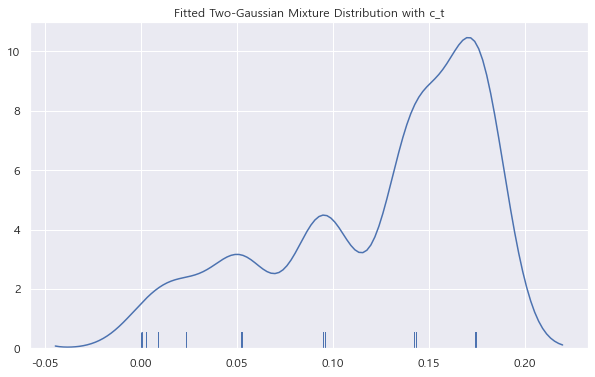

In [64]:
# Fit된 그래프
plt.figure(figsize=(10,6))
plt.title('Fitted Two-Gaussian Mixture Distribution with c_t')

sns.distplot(pdf_mixture(c_t, params_list), hist=False, rug=True);

## 4(c)
m_t 구하기

In [65]:
# F: cdf_mixture와 c_t를 이용해 m_t 반환
def bet_size_mixed(c_t, parameters):
    # return the bet size based on the description provided in
    # question 10.4(c).
    # :param c_t: (int) different of the number of concurrent long bets minus short bets
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) bet size
    # =========================
    if c_t >= 0:
        return ( bs.cdf_mixture(c_t, parameters) - bs.cdf_mixture(0, parameters) ) / ( 1 - bs.cdf_mixture(0, parameters) )
    else:
        ( bs.cdf_mixture(c_t, parameters) - bs.cdf_mixture(0, parameters) ) / bs.cdf_mixture(0, parameters)

In [66]:
bet_size_4 = pd.Series() #m_t를 담을 새 series
bet_size_4 = c_t.apply(lambda c: bet_size_mixed(c, params_list))
bet_size_4

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


2015-01-05 17:26:59         NaN
2015-01-06 16:19:17         NaN
2015-01-06 18:27:02         NaN
2015-01-06 19:53:59         NaN
2015-01-07 13:06:59    0.476676
                         ...   
2016-12-09 20:17:20    0.476676
2016-12-13 17:16:09    0.476676
2016-12-14 20:09:51    0.000000
2016-12-15 16:03:52    0.476676
2016-12-28 17:41:36    0.000000
Length: 772, dtype: float64

### bet_size_reserve 모듈로 m_t 구하기

In [83]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=tripple_barrier_events['t1'], sides=tripple_barrier_events.side, return_parameters=True, fit_runs=30)
m_reserve[0].bet_size

|#########################| Completed 30 of 30 fitting rounds.

2015-01-05 17:26:59   -0.212570
2015-01-06 16:19:17   -0.212570
2015-01-06 18:27:02   -0.212570
2015-01-06 19:53:59   -0.212570
2015-01-07 13:06:59    0.477672
                         ...   
2016-12-09 20:17:20    0.477672
2016-12-13 17:16:09    0.477672
2016-12-14 20:09:51    0.000000
2016-12-15 16:03:52    0.477672
2016-12-28 17:41:36    0.000000
Name: bet_size, Length: 772, dtype: float64

## 4(d)
3에서 구한 bet size와 4에서 구한 bet size가 어떻게 다른가?

In [75]:
bet_size_3 == bet_size_4

2015-01-05 17:26:59    False
2015-01-06 16:19:17    False
2015-01-06 18:27:02    False
2015-01-06 19:53:59    False
2015-01-07 13:06:59    False
                       ...  
2016-12-09 20:17:20    False
2016-12-13 17:16:09    False
2016-12-14 20:09:51    False
2016-12-15 16:03:52    False
2016-12-28 17:41:36    False
Length: 772, dtype: bool

In [76]:
bet_size_3

2015-01-05 17:26:59   -0.071429
2015-01-06 16:19:17   -0.071429
2015-01-06 18:27:02   -0.071429
2015-01-06 19:53:59   -0.071429
2015-01-07 13:06:59    0.062500
                         ...   
2016-12-09 20:17:20    0.062500
2016-12-13 17:16:09    0.062500
2016-12-14 20:09:51   -0.008929
2016-12-15 16:03:52    0.053571
2016-12-28 17:41:36   -0.017857
Length: 772, dtype: float64

In [77]:
bet_size_4

2015-01-05 17:26:59         NaN
2015-01-06 16:19:17         NaN
2015-01-06 18:27:02         NaN
2015-01-06 19:53:59         NaN
2015-01-07 13:06:59    0.476676
                         ...   
2016-12-09 20:17:20    0.476676
2016-12-13 17:16:09    0.476676
2016-12-14 20:09:51    0.000000
2016-12-15 16:03:52    0.476676
2016-12-28 17:41:36    0.000000
Length: 772, dtype: float64

- 4번의 bet size는 가우시안 분포에 fit하여 구해졌기 때문에 양수, 값이 클 수 밖에 없음. (signal의 강/약)
- 3번의 bet size는 (long bets 개수/max  - short bets 개수/max이기 때문에 음수가 나올 수 있으며, 값이 작음. 